In [1]:
import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import inv, norm, det

import os
os.chdir('/home/kei/Desktop/dpp/')

import sampler.dpp as dpp
import sampler.mcdpp as mcdpp
import sampler.utils as utils

In [2]:
# currently only support cpu mode
flag_gpu = False

lmbd = 1e-4
nTrn = 4000
nTot = 5000
data = pd.read_csv('data/ailerons.txt')[:nTot].values
trnY = data[:nTrn, -1]
tstY = data[nTrn:, -1]
pairwise_dists = squareform(pdist(data[:,:-1], 'euclidean'))
L = np.exp(-pairwise_dists ** 2 / 100 ** 2)
trnL = L[:nTrn, :nTrn]

In [3]:
def KL_multi_Gaussian(mu0, S0, mu1, S1):
    
    assert(len(mu0)==len(mu1))
    assert(S0.shape==S1.shape)
    
    k = len(mu0)
    invS1 = inv(S1)
    tr = sum(invS1*S0)
    quad = (mu1-mu0) @ invS1 @ (mu1-mu0)
    logdet = np.log(det(S1)/det(S0))
    
    return 1/2 * (tr + quad - k + logdet)

In [4]:
def KL_Gaussian(mu0, sigsq0, mu1, sigsq1):
    return 1/2 * (np.log(sigsq1)-np.log(sigsq0) + sigsq0/sigsq1 - 1 + (mu0-mu1)**2/sigsq1**2)

def KL_Gaussian_vec(vec):
    [mu0, sigsq0, mu1, sigsq1] = list(vec)
    return KL_Gaussian(mu0, sigsq0, mu1, sigsq1)

# Full GP

In [5]:
sigma2 = lmbd*nTrn
inv_mat = inv(trnL + sigma2 * np.identity(nTrn))
alpha = inv_mat @ trnY
Y_hat_full = L[:,:nTrn]@ alpha
Var_Y_hat_full = L - L[:,:nTrn] @ inv_mat @ L[:nTrn,:] + sigma2 * np.identity(L.shape[0])
error_full_trn = norm(Y_hat_full[:nTrn] - trnY)
error_full_tst = norm(Y_hat_full[nTrn:] - tstY)

# Nystrom GP

In [6]:
k_group = [20,30,50,70,100]
error_unif = np.zeros((4, len(k_group)))
error_dpp = np.zeros((4, len(k_group)))
error_mcdpp = np.zeros((4, len(k_group)))

for run_id in range(10):
    for k_idx in range(len(k_group)):
        k = k_group[k_idx]
        
        # Uniform sampling
        unif_smpl = np.random.permutation(nTrn)[:k]

        C = trnL[np.ix_(range(nTrn), unif_smpl)]
        W = C[np.ix_(unif_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_unif[0,k_idx] += norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY) )
        Var_Y_hat = L[np.ix_(range(nTot), unif_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), unif_smpl)].T + sigma2 * np.identity(L.shape[0])
        
        error_unif[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_unif[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]
            ]).T
        error_unif[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=KL_Gaussian_vec).mean()
        
        # DPP
        D, V = utils.get_eig(trnL, flag_gpu=flag_gpu)
        E = utils.get_sympoly(D, k, flag_gpu=flag_gpu)
        dpp_smpl  = dpp.sample(D, V, E=E, k=k, flag_gpu=flag_gpu)

        C = trnL[np.ix_(range(nTrn), dpp_smpl)]
        W = C[np.ix_(dpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_dpp[0,k_idx] += norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), dpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), dpp_smpl)].T + sigma2 * np.identity(L.shape[0])
        error_dpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_dpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]
            ]).T
        error_dpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=KL_Gaussian_vec).mean()

        #MC-DPP
        #too slow to wait mixing
        mcdpp_smpl  = mcdpp.sample(L[:nTrn,:nTrn], mix_step=k*nTrn//100, k=k, flag_gpu=flag_gpu, silent=True)

        C = trnL[np.ix_(range(nTrn), mcdpp_smpl)]
        W = C[np.ix_(mcdpp_smpl, range(k))]
        trnL_prime = C @ inv(W) @ C.T
        error_mcdpp[0,k_idx] += norm(trnL_prime - trnL, 'fro')
        
        W_inv = inv(W)
        CC = C.T @ C
        A = CC @ W_inv
        B = inv(sigma2*W + CC)
        Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY))
        Var_Y_hat = L[np.ix_(range(nTot), mcdpp_smpl)] @ (
                        W_inv - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                    ) @ L[np.ix_(range(nTot), mcdpp_smpl)].T + sigma2 * np.identity(L.shape[0])
        error_mcdpp[1,k_idx] += norm(Y_hat[:nTrn] - trnY)
        error_mcdpp[2,k_idx] += norm(Y_hat[nTrn:] - tstY)
        tmp = np.stack([
                Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:], 
                Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:]
            ]).T
        error_mcdpp[3,k_idx] += np.apply_along_axis(arr=tmp,axis=1,func1d=KL_Gaussian_vec).mean()
        


# Plot

In [7]:
%matplotlib inline

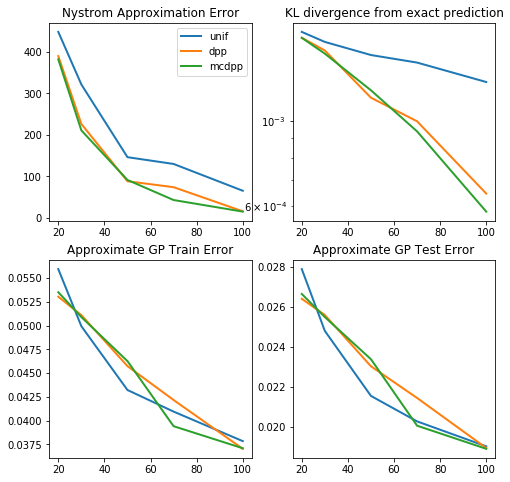

In [8]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title('Nystrom Approximation Error')
plt.plot(k_group, error_unif[0] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[0] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[0] / 5., label='mcdpp', lw=2)
plt.legend()
plt.savefig('fig/nystrom', bbox_inches='tight')

plt.subplot(2,2,2)
plt.title('KL divergence from exact prediction')
plt.plot(k_group, error_unif[3] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[3] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[3] / 5., label='mcdpp', lw=2)
plt.plot([])
plt.yscale('log')


plt.subplot(2,2,3)
plt.title('Approximate GP Train Error')
plt.plot(k_group, error_unif[1] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[1] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[1] / 5., label='mcdpp', lw=2)
plt.subplot(2,2,4)
plt.title('Approximate GP Test Error')
plt.plot(k_group, error_unif[2] / 5., label='unif', lw=2)
plt.plot(k_group, error_dpp[2] / 5., label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[2] / 5., label='mcdpp', lw=2)

plt.savefig('fig/gp_regression', bbox_inches='tight')

In [9]:
tmp[:20]

array([[-0.0005423 ,  0.42194472, -0.00067272,  0.41492613],
       [-0.00097883,  0.4026812 , -0.00097461,  0.402417  ],
       [-0.00086251,  0.40492079, -0.00082885,  0.40423873],
       [-0.00063035,  0.40602007, -0.00066624,  0.40469037],
       [-0.00074599,  0.4197726 , -0.00071214,  0.41658269],
       [-0.00103564,  0.40180729, -0.00103353,  0.40158298],
       [-0.00058781,  0.40260239, -0.00060655,  0.40218246],
       [-0.00056164,  0.4070903 , -0.00051517,  0.40521752],
       [-0.0008345 ,  0.40233934, -0.00083632,  0.4020425 ],
       [-0.0012977 ,  0.41914374, -0.00125725,  0.41425905],
       [-0.00108267,  0.41113911, -0.00097286,  0.40831512],
       [-0.00071237,  0.40491973, -0.00070574,  0.40352911],
       [-0.0007705 ,  0.43056767, -0.00078723,  0.4263053 ],
       [-0.00074723,  0.40515937, -0.00078649,  0.40228422],
       [-0.00123505,  0.41147942, -0.00123041,  0.40951004],
       [-0.00083929,  0.40733123, -0.00083924,  0.40619227],
       [-0.00059549,  0.

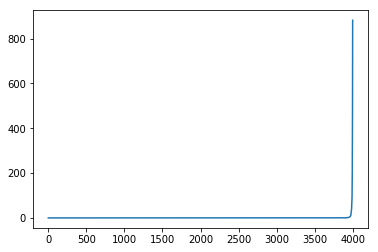

In [23]:
plt.plot(D)